In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=ebd0df939e06fd58c7dbc0defc5f0d47a2c2389c88c29b544e2e6698bc7b1b1f
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 111.9 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
model_inception_net_v3 = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
model_inception_net_v3.trainable = False

87916544/87910968 [==============================] - 0s 0us/step


In [ ]:
model_inception_net_v3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
import numpy as np
import cv2 as cv

In [ ]:
batch_size = 128

In [ ]:
train = ImageDataGenerator(rescale=1/255,
                            width_shift_range=0.15,
                            height_shift_range=0.15,
                            shear_range=0.2,
                            zoom_range=0.5,
                            fill_mode='nearest')
validation = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

In [ ]:
train_dataset = train.flow_from_directory('/content/drive/MyDrive/Dataset/anti_spoofing/train/',
                                          target_size=(224,224),
                                          batch_size=batch_size,
                                          class_mode='binary')

validation_dataset = validation.flow_from_directory('/content/drive/MyDrive/Dataset/anti_spoofing/validation/',
                                          target_size=(224,224),
                                          batch_size=batch_size,
                                          class_mode='binary')

test_dataset = test.flow_from_directory('/content/drive/MyDrive/Dataset/anti_spoofing/test/',
                                          target_size=(224,224),
                                          batch_size=batch_size,
                                          class_mode='binary')

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
s_p_e = 6000 // batch_size
v_s = 2000 // batch_size
train_dataset.class_indices

{'live': 0, 'spoof': 1}

In [ ]:
print("Number of layers in the base model: ", len(model_inception_net_v3.layers))

Number of layers in the base model:  311


In [ ]:
# Fine-tune from this layer onwards
#fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
#for layer in mobileNetV2.layers[:fine_tune_at]:
#  layer.trainable =  False

In [ ]:
model = tf.keras.models.Sequential([
    model_inception_net_v3,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

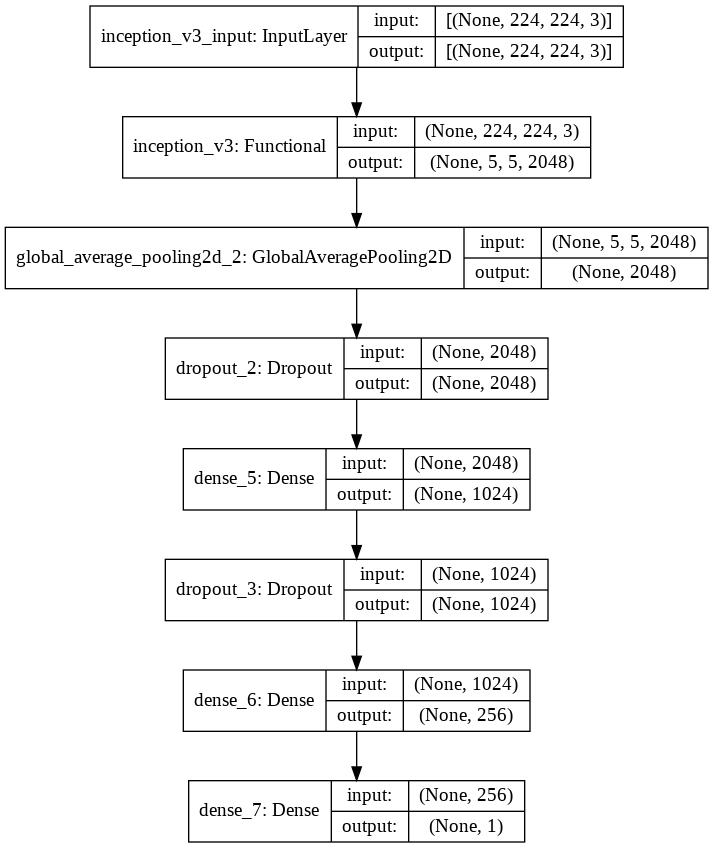

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, 'model_top.png', show_shapes=True)

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
#model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=20, steps_per_epoch=s_p_e, validation_data = validation_dataset, verbose = 1, validation_steps=v_s)

Epoch 1/20
46/46 [==============================] - 2698s 58s/step - loss: 0.9340 - accuracy: 0.5574 - precision_1: 0.5449 - recall_1: 0.5371 - val_loss: 0.5273 - val_accuracy: 0.7531 - val_precision_1: 0.7043 - val_recall_1: 0.8754
Epoch 2/20
46/46 [==============================] - 73s 2s/step - loss: 0.5262 - accuracy: 0.7324 - precision_1: 0.7253 - recall_1: 0.7487 - val_loss: 0.4697 - val_accuracy: 0.7635 - val_precision_1: 0.7598 - val_recall_1: 0.7678
Epoch 3/20
46/46 [==============================] - 73s 2s/step - loss: 0.4890 - accuracy: 0.7621 - precision_1: 0.7629 - recall_1: 0.7578 - val_loss: 0.4388 - val_accuracy: 0.8021 - val_precision_1: 0.7517 - val_recall_1: 0.8996
Epoch 4/20
46/46 [==============================] - 73s 2s/step - loss: 0.4922 - accuracy: 0.7672 - precision_1: 0.7660 - recall_1: 0.7606 - val_loss: 0.4223 - val_accuracy: 0.7995 - val_precision_1: 0.7884 - val_recall_1: 0.8204
Epoch 5/20
46/46 [==============================] - 73s 2s/step - loss: 0.439

In [ ]:
loss0,accuracy0,precision0,recall0 = model.evaluate(test_dataset)

print("Test loss: {:.2f}".format(loss0))
print("Test accuracy: {:.2f}".format(accuracy0))
print("Test precision: {:.2f}".format(precision0))
print("Test recall: {:.2f}".format(recall0))

16/16 [==============================] - 617s 41s/step - loss: 0.3641 - accuracy: 0.8580 - precision_1: 0.8866 - recall_1: 0.8210
Test loss: 0.36
Test accuracy: 0.86
Test precision: 0.89
Test recall: 0.82


In [ ]:
model.save('/content/drive/MyDrive/Dataset/anti_spoofing/feature_extraction.h5')

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

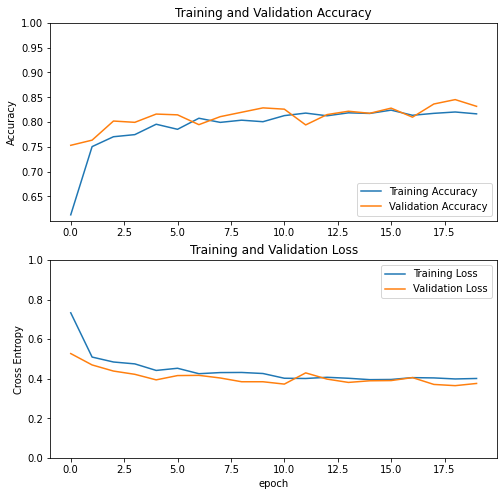

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

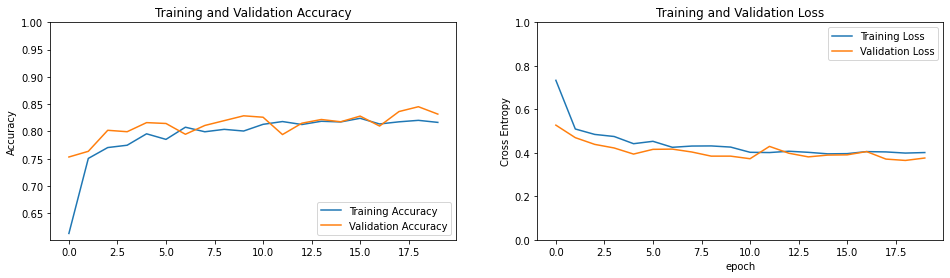

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()